Check the coordinate transforms from trajectory segment to segment

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import namedtuple

In [21]:
# Find the endpoint (in forward-right-down coordinates) and tangent direction of the arc segment after dt s.
def transform(curvature, speed, dt):
    if abs(curvature) < 1e-300:
        endpoint = np.array([speed * dt, 0])
        return endpoint, 0
    theta = speed * curvature * dt
    c, s = math.cos(theta), math.sin(theta)
    r = 1/curvature
    endpoint = r * np.array([s, -1 + c])
    return endpoint, theta

Text(0, 0.5, 'theta')

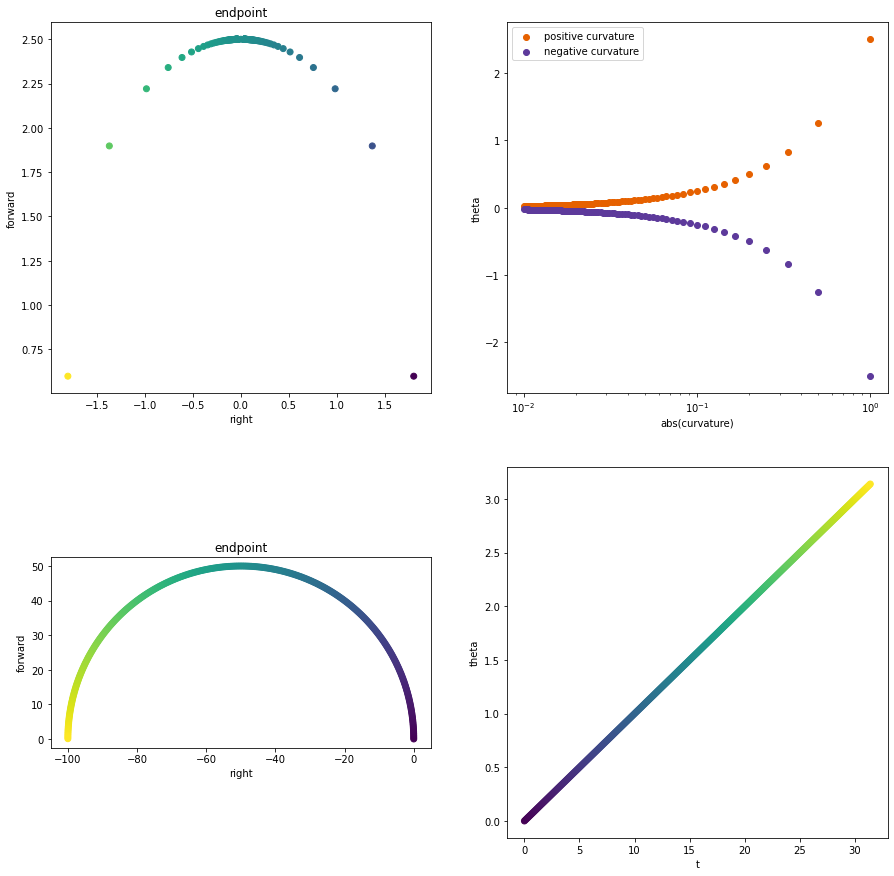

In [22]:
# Find the endpoint and direction for various curvatures
speed = 5
dt = 0.5
curvatures_pos =  1 / np.arange(1, 100, 1)
curvatures = np.concatenate((curvatures_pos, np.array([0]), -curvatures_pos))
transforms = [transform(curvature, speed, dt) for curvature in curvatures]
fs, rs = [transform[0][0] for transform in transforms], [transform[0][1] for transform in transforms]
thetas = [transform[1] for transform in transforms]

fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(15, 15))

ax = axes[0, 0]
ax.scatter(rs, fs, c=curvatures, cmap="viridis")
ax.set_ylabel("forward")
ax.set_xlabel("right")
ax.set_title("endpoint")
ax = axes[0, 1]
ax.scatter(np.abs(curvatures[curvatures >= 0]), np.array(thetas)[curvatures >= 0], c="#E66100", label="positive curvature")
ax.scatter(np.abs(curvatures[curvatures < 0]), np.array(thetas)[curvatures < 0], c="#5D3A9B", label="negative curvature")
ax.legend()
ax.set_xlabel("abs(curvature)")
ax.set_ylabel("theta")
ax.set_xscale("log")

# Find the endpoint and direction for a sequence of dt's.
curvature = 1/50.0
speed = 5
dts = np.arange(0, math.pi/speed/curvature, 0.1)
transforms = [transform(curvature, speed, dt) for dt in dts]
fs, rs = [transform[0][0] for transform in transforms], [transform[0][1] for transform in transforms]
thetas = [transform[1] for transform in transforms]

ax = axes[1, 0]
ax.scatter(rs, fs, c=dts)
ax.set_aspect('equal', 'box')
ax.set_xlabel('right')
ax.set_ylabel('forward')
ax.set_title("endpoint")

ax = axes[1, 1]
ax.scatter(dts, thetas, c=dts)
ax.set_xlabel('t')
ax.set_ylabel('theta')

In [23]:
# Find points along the trajectory
def trjpts(trajectory, tstep):
    dts = np.arange(0, trajectory.dt, tstep) 
    transforms = [transform(trajectory.curvature, trajectory.speed, dt) for dt in dts]
    return [transform[0] for transform in transforms]


In [24]:
COLOR = [
'#000000',
'#E69F00',
'#56B4E9',
'#009E73',
'#F0E442',
'#0072B2',
'#D55E00',
'#CC79A7']

In [25]:
Trajectory = namedtuple('Trajectory', ['curvature', 'speed', 'dt'])
curvature=1/30
speed = 5
dt = math.pi /5 / speed / curvature
trajectories = [Trajectory(curvature = curvature, speed=speed, dt=dt),
                Trajectory(curvature = -curvature, speed=speed, dt=2*dt),
                Trajectory(curvature = 0.8*curvature, speed=0.7*speed, dt=dt),
                Trajectory(curvature = 2*curvature, speed=1.5*speed, dt=2.5*dt),
                Trajectory(curvature=0, speed=speed, dt=1.5*dt),
                Trajectory(curvature=0, speed=speed, dt=0.5*dt),
               ]
print(f"dt {dt:.2f} s")            

dt 3.77 s


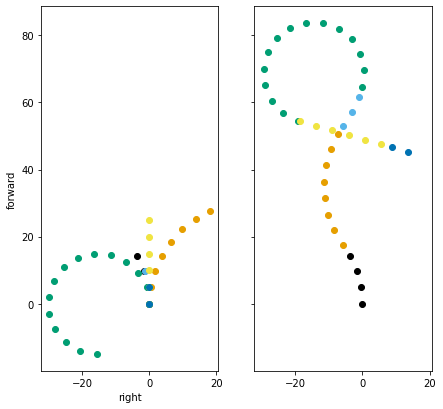

In [30]:
tstep = 0.1
cumulative_theta = 0
basepoint = np.array([0.0, 0.0])
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(7, 7),
                         sharex=True, sharey=True)
ax_raw = axes[0, 0]
ax_raw.set_aspect('equal')
ax_transformed = axes[0, 1]
ax_transformed.set_aspect('equal')
ax_raw.set_xlabel('right')
ax_raw.set_ylabel('forward')
for i, trj in enumerate(trajectories):
    # Draw points in the trajectory's coordinate system
    s_per_meter = 1/trj.speed
    pts = trjpts(trj, 5*s_per_meter)
    fs, rs = [pt[0] for pt in pts], [pt[1] for pt in pts]
    ax_raw.scatter(rs, fs, c=COLOR[i%len(COLOR)])
    
    # Apply the cumulative transform
    c, s = math.cos(cumulative_theta), math.sin(cumulative_theta)
    rot = np.array([[c, s], [-s, c]])
    rotated = [np.matmul(rot, pt) for pt in pts]
    translated = [rot + basepoint for rot in rotated]
    fs, rs = [pt[0] for pt in translated], [pt[1] for pt in translated]
    ax_transformed.scatter(rs, fs, c=COLOR[i%len(COLOR)])

    # update the cumulative transform
    end_xform = transform(trj.curvature, trj.speed, trj.dt)
    cumulative_theta += end_xform[1]
    # Don't forget to rotate the endpoint before adding.
    basepoint += np.matmul(rot, end_xform[0])
